In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import ipdb

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

## Monte Carlo Policy Evaluation
In a single Blackjack episode, each state is visited at most once because:
- The player's sum can only increase or terminate the game.
- The state transitions are deterministic given the player's action.
  
So in this case, First-Visit MC and Every-Visit MC produce the same value estimates.

To estimate the expected return $ V(s) = \mathbb{E}_\pi[G_t \mid S_t = s]$ for each state $s$, using **Monte Carlo sampling** over multiple episodes generated by a **given policy** $\pi$.

### 🧠 Pipeline
1. **Initialize value trackers:**
   - `returns_sum`: total accumulated returns from each state.
   - `returns_count`: how many times each state was visited.
   - `V`: the estimated value function, computed as the average return.

2. **Simulate episodes:**
   - For `num_episodes`, simulate an episode using the provided `policy`.
   - An episode is a sequence of $(s_t, a_t, r_t)$ tuples until the terminal state.

3. **First-visit MC return estimation:**
   - For each **unique state** visited in an episode, find the **first occurrence**.
   - Compute the **discounted return** $G$ from that point to the end of the episode:
     $$
     G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots
     $$
   - Update the **running average** of returns to estimate $V(s)$.


### 📌 Notes
- This is **first-visit** MC prediction: each state is only updated once per episode.
- It does not require knowledge of the environment's transition model (model-free).
- The `policy` must be a function mapping a state to an **action**.

In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
    
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [6]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
V_500k = mc_prediction(sample_policy, env, num_episodes=500000)

Episode 500000/500000.

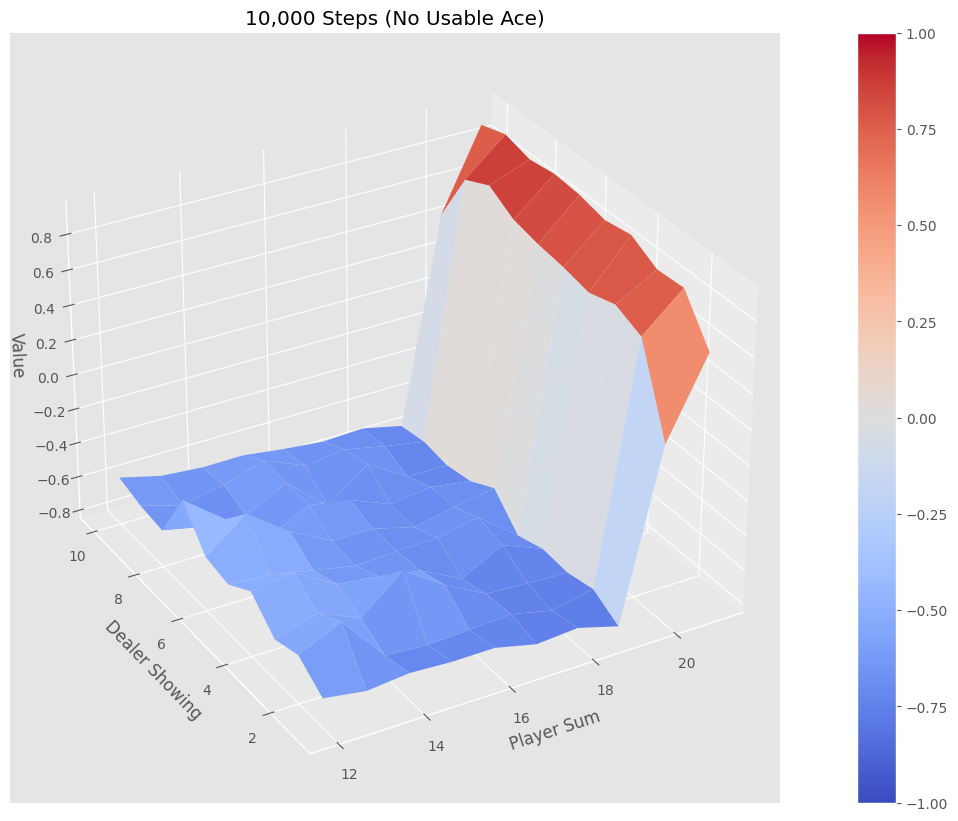

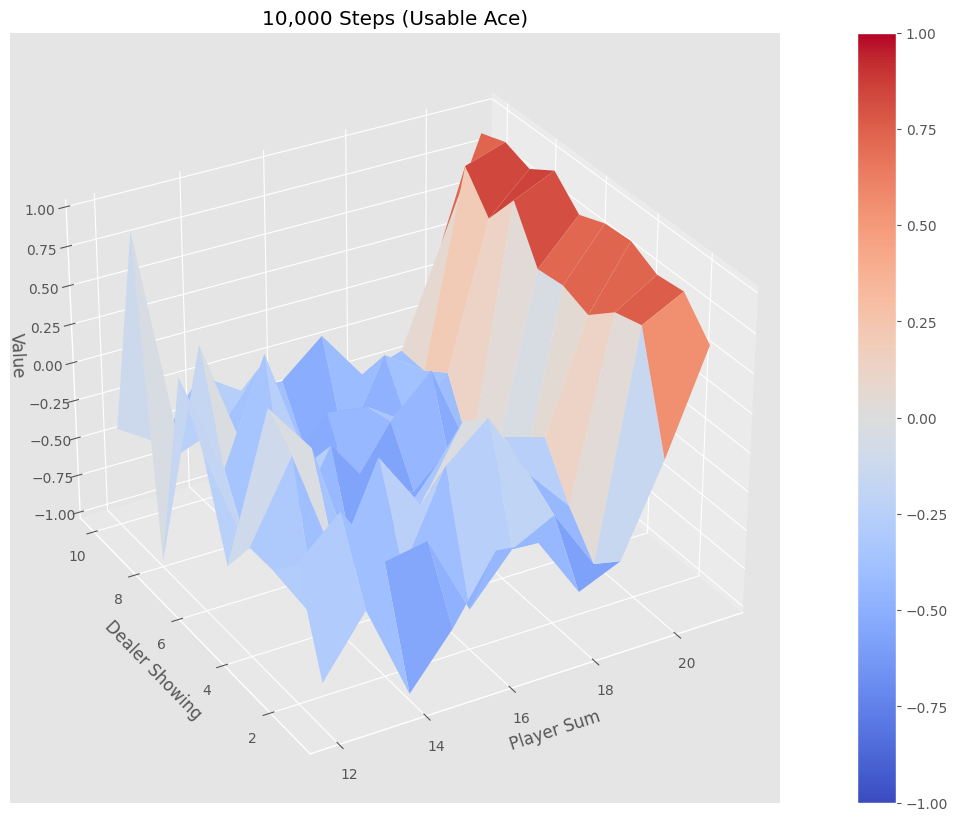

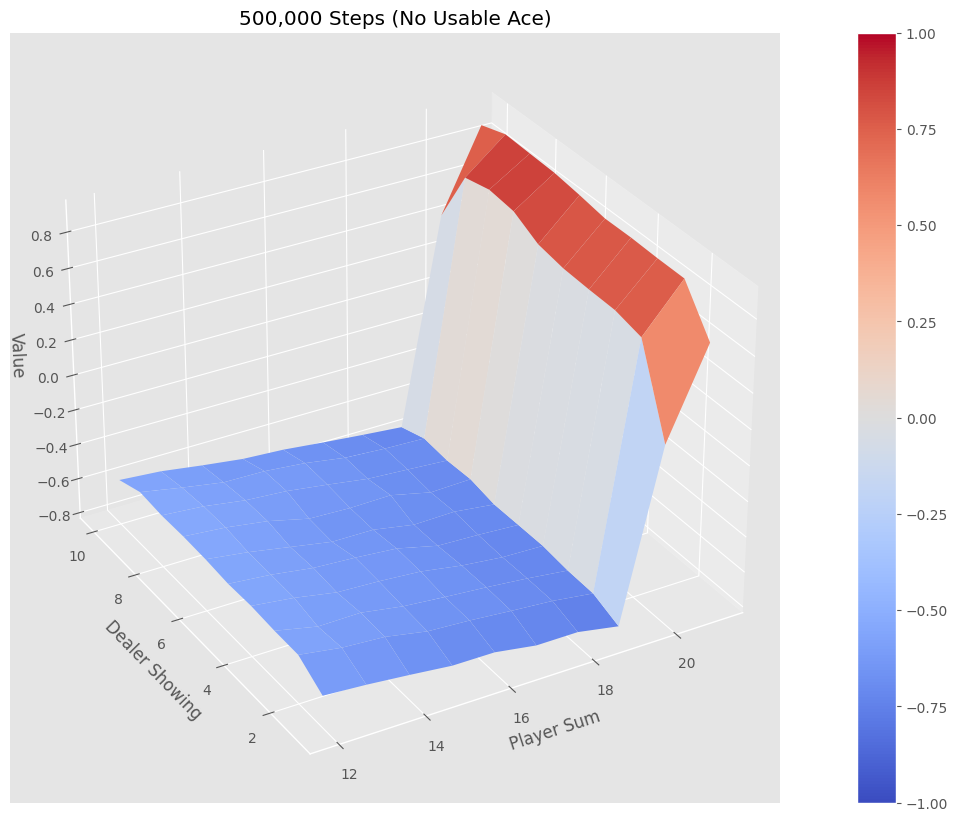

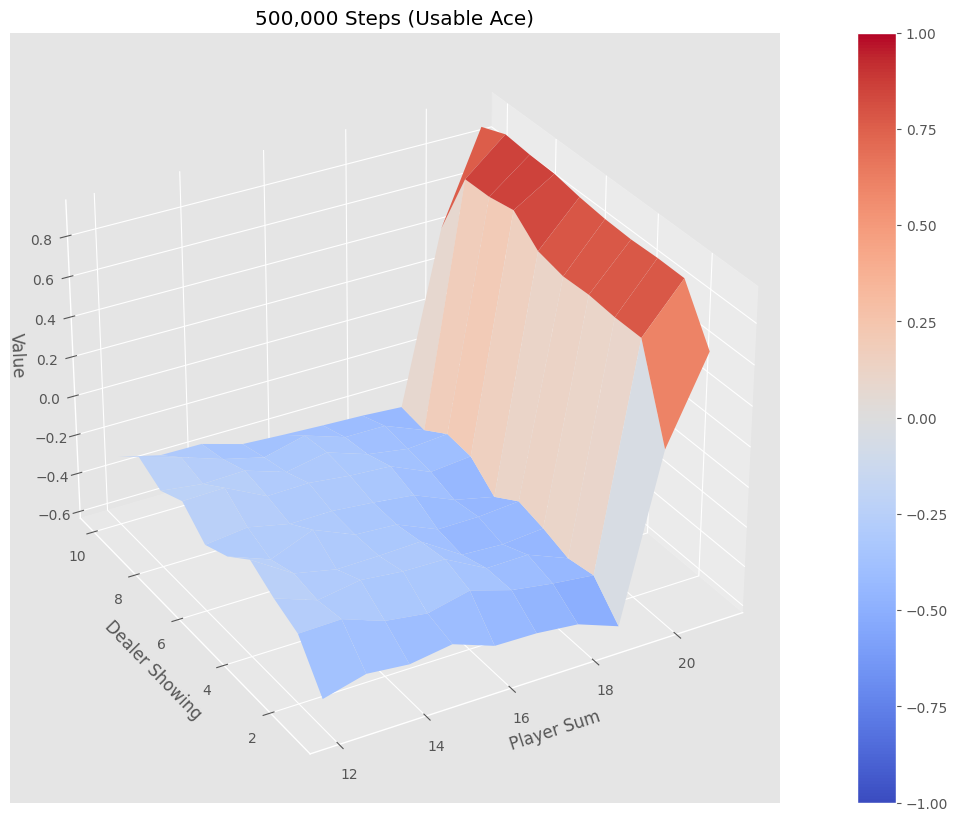

In [7]:
plotting.plot_value_function(V_10k, title="10,000 Steps")
plotting.plot_value_function(V_500k, title="500,000 Steps")